# LB Probing - Testのdata sourceの配分の推定

仮説: 「testのdata sourceの分布はhigh qualityが大半を占める」

上記仮説について確認するためのLB probe手法について検討する。

まずは、CVにてgiziの投稿[1]（現在は削除ずみ）で彼やったと思われるLB Probe手法の有効性について検証する。

ヒントとなりうる情報:

> I have done online test probe as below, it show online predict entropy more like to n_votes >= 10 dataset only.
> So trust on local cv with n_votes >=10 rather then cv with all data, this will make this competion more interseting.

「Testでモデルの予測分布のentropyを計測し、local CVのn_votes >= 10のentropyと近い傾向があることを確認した」

> @mohammad2012191 is correct I found model train on high votes has similar entropy on vote < 9 and vote > 9, but if you train on all data then your model should predict high entropy on votes > 0.9, likely 0.9+ and for <9 about 0.6+, sorry I forgot the exact value.

「high voteだけで訓練したモデルはvote<9と>=9で似たentropyを示すが、全データで学習したモデルには両者に差が見られた」


## Reference

- [1] https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/484099

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from seaborn import heatmap

from src.constant import LABELS
from src.preprocess import process_label

plt.style.use("tableau-colorblind10")

import matplotlib.pyplot as plt

from src.error_analysis import calc_conditional_prob

In [13]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"gt_{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)

## データソースの定義

* `very low quality`: weight < 0.1; vote数3未満
* `low quality`: 0.1 <= weight < 0.3; vote数3以上9未満
* `high quality`: 0.3 <= weight; vote数9以上


In [3]:
low_quality = metadata.filter(pl.col("weight") < 0.3).filter(pl.col("weight") >= 0.1)
high_quality = metadata.filter(pl.col("weight") >= 0.3)

## targetモデル

- `v5_spec_8ep_cutmix_all_data`: all data, weight=1で8epoch学習したモデル(specベース)

In [4]:
def sum_over_labels(labels) -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"pl_{label}_vote")
    return x


pred_df = pl.read_parquet(
    "../data/pseudo_label/v5_spec_8ep_cutmix_all_data/train_pseudo_label.pqt"
)
pred_df = (
    pred_df.with_columns(pl.col(f"pl_{label}_vote").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"{label}_prob")
        for label in LABELS
    )
).drop("weight", *[f"pl_{label}_vote" for label in LABELS], "pl_vote")
pred_low_quality = pred_df.join(low_quality, on="eeg_id", how="inner")
pred_high_quality = pred_df.join(high_quality, on="eeg_id", how="inner")

## 条件付き確率の定義

条件付き確率P(i | j)は、クラスi-j間での「専門家の混同しやすさ」を表していると考えられる。

基本的な考え方:

1. クラスのペア(i, j)に対して、両者のGT確率の積を計算して全サンプルで平均を取ることで全確率を求める。
2. 1で計算した全確率を周辺確率で割って正規化することで、条件付き確率P(i | j)を求める

厳密な定義:

$$
P(y_\text{pred} = j | y_\text{GT} = i) := \frac{P(y_\text{GT} = i, y_\text{pred} = j)}{P_{y_\text{GT}}(i)} \\\\
P_{y_\text{GT}}(i) := \sum_j P(y_\text{GT} = i, y_\text{pred} = j)
$$

$$
P(y_\text{GT} = i | y_\text{pred} = j) := \frac{P(y_\text{GT} = i, y_\text{pred} = j)}{P_{y_\text{pred}}(j)} \\\\
P_{y_\text{pred}}(j) := \sum_i P(y_\text{GT} = i, y_\text{pred} = j)
$$

## (参考)各データソースにおけるGTラベルの票の割れ具合

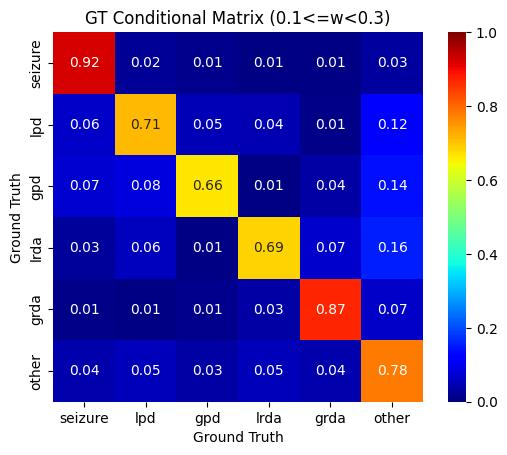

In [5]:
gts_low_quality = pred_low_quality.select(
    *[f"gt_{label}_prob" for label in LABELS]
).to_numpy()
preds_low_quality = pred_low_quality.select(
    *[f"{label}_prob" for label in LABELS]
).to_numpy()


_, ax = plt.subplots()
confusion_low_quality = calc_conditional_prob(gts_low_quality, gts_low_quality, norm_axis=1)
heatmap(
    confusion_low_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="Ground Truth", ylabel="Ground Truth", title="GT Conditional Matrix (0.1<=w<0.3)"
)
plt.show()

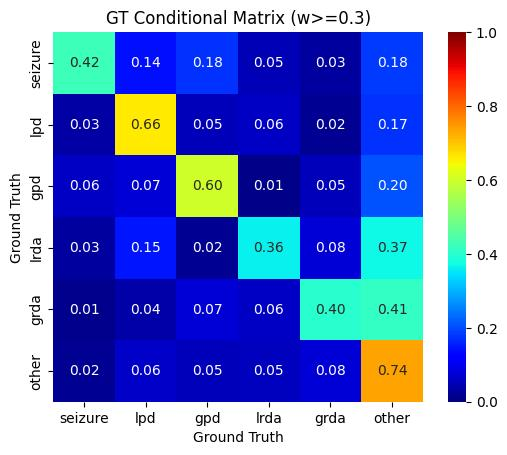

In [6]:
gts_high_quality = pred_high_quality.select(
    *[f"gt_{label}_prob" for label in LABELS]
).to_numpy()
preds_high_quality = pred_high_quality.select(
    *[f"{label}_prob" for label in LABELS]
).to_numpy()

_, ax = plt.subplots()
confusion_high_quality = calc_conditional_prob(gts_high_quality, gts_high_quality, norm_axis=1)
heatmap(
    confusion_high_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="Ground Truth", ylabel="Ground Truth", title="GT Conditional Matrix (w>=0.3)"
)
plt.show()

## (参考)各データソースにおけるモデルの予測分布の票の割れ具合

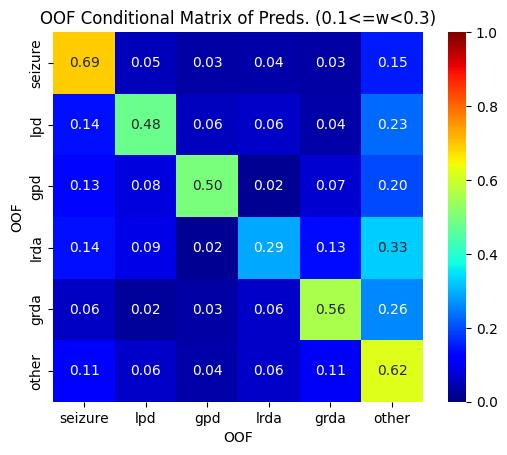

In [7]:
_, ax = plt.subplots()
confusion_preds_low_quality = calc_conditional_prob(preds_low_quality, preds_low_quality, norm_axis=1)
heatmap(
    confusion_preds_low_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="OOF", ylabel="OOF", title="OOF Conditional Matrix of Preds. (0.1<=w<0.3)"
)
plt.show()

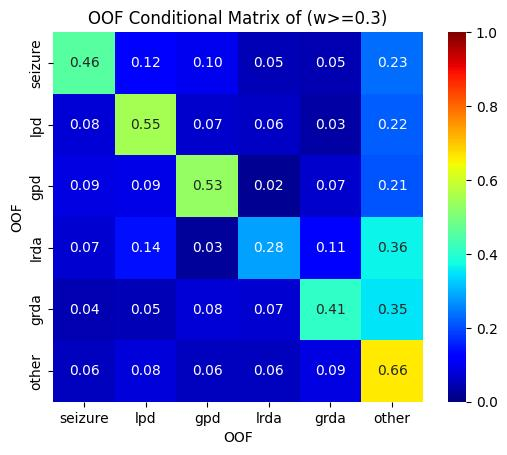

In [8]:
_, ax = plt.subplots()
confusion_preds_high_quality = calc_conditional_prob(preds_high_quality, preds_high_quality, norm_axis=1)
heatmap(
    confusion_preds_high_quality,
    annot=True,
    fmt=".2f",
    cmap="jet",
    xticklabels=LABELS,
    yticklabels=LABELS,
    square=True,
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set(
    xlabel="OOF", ylabel="OOF", title="OOF Conditional Matrix of (w>=0.3)"
)
plt.show()

## (参考)各データセットのレコード数

In [9]:
print("num_records_low_quality:", preds_low_quality.shape[0])
print("num_records_high_quality:", preds_high_quality.shape[0])

num_records_low_quality: 6689
num_records_high_quality: 5525


## data sourceごとのモデルの予測分布のEntropy

In [10]:
entropy_low_quality = (
    (-preds_low_quality * np.log(preds_low_quality)).sum(axis=1).mean()
)
entropy_high_quality = (
    (-preds_high_quality * np.log(preds_high_quality)).sum(axis=1).mean()
)

print(f"entropy_low_quality: {entropy_low_quality:.4f}")
print(f"entropy_high_quality: {entropy_high_quality:.4f}")

entropy_low_quality: 0.8222
entropy_high_quality: 0.8807


## Seizureクラスの予測確率の平均

In [11]:
class_id = 0
prob_low = preds_low_quality[:, class_id].mean()
prob_high = preds_high_quality[:, class_id].mean()

print(f"low_quality: {prob_low:.4f}")
print(f"high_quality: {prob_high:.4f}")

low_quality: 0.2619
high_quality: 0.1045


In [12]:
for class_id, label in enumerate(LABELS):
    prob_low = preds_low_quality[:, class_id].mean()
    prob_high = preds_high_quality[:, class_id].mean()

    print(f"** {label} **")
    print(f"p(low_quality): {prob_low:.3f}")
    print(f"p(high_quality): {prob_high:.3f}")
    print()

** seizure **
p(low_quality): 0.262
p(high_quality): 0.105

** lpd **
p(low_quality): 0.100
p(high_quality): 0.163

** gpd **
p(low_quality): 0.068
p(high_quality): 0.120

** lrda **
p(low_quality): 0.069
p(high_quality): 0.069

** grda **
p(low_quality): 0.145
p(high_quality): 0.108

** other **
p(low_quality): 0.356
p(high_quality): 0.435



## 結果

all_dataで学習したモデルのdata_sourceごとの予測分布について、

1. entropyはdata sourceごとに大きな差異が見られなかった(low_quality: 0.8222, high_quality: 0.8807)
1. seizureクラスの予測確率の平均値ではかなり明確な違いが見られた(low_quality: 0.262, high_quality: 0.105)


## 考察

testの配分として、以下のようなパターンが考えられる(competition pageのdata descriptionにtestのvote数は3-20という記述があるのでvery_low_qualityは除外できる)

1. low_quality : high_quality = $0:1$
3. low_quality : high_quality = $1-\alpha:\alpha$

geziがCVでのentropyを計算する際に、very_low_quality(weight<0.1)を除外していなかったならば、1と2を正確に判別できていなかった可能性がある。
逆に、seizureの確率に関してLB Probeを行えば1 vs 2の仮定のどちらが正しいかを正確に判定できる可能性がある。